# 4. Pretrain Word2Vec

We go on to implement the skip-gram model defined in [Section 1](./readme.md). Then we will pretrain word2vec using negative sampling on the PTB dataset. First of all, let us obtain the data iterator and the vocabulary for this dataset by calling the `d2l.load_data_ptb` function, which was described in [Section 3](./readme.md)

In [4]:
import math
import torch
from torch import nn

from C14_3_Dataset import *
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

## 4.1 The Skip-Gram Model

We implement the skip-gram model by using embedding layers and batch matrix multiplications. 

First, let us review how embedding layers work.

### 4.1.1 Embedding Layer

An embedding layer *maps* a **token’s index** to its **feature vector**. The weight of this layer is a matrix whose number of rows equals to the dictionary size (input_dim) and number of columns equals to the vector dimension for each token (output_dim). After a word embedding model is trained, this weight is what we need.

In [7]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype}')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32


The input of an embedding layer is the index of a token (word). For any token index $i$, its vector representation can be obtained from the $i^{th}$ row of the weight matrix in the embedding layer. Since the vector dimension (`output_dim`) was set to 4, the embedding layer returns vectors with shape (2, 3, 4) for a minibatch of token indices with shape (2, 3).

In [8]:
x = torch.tensor([[1,2,3], [4,5,6]]) ## a minibatch of token indices with shape (2, 3).
embed(x) ##  returns vectors with shape (2, 3, 4) 

tensor([[[-2.8184,  0.8259,  0.5888, -0.4435],
         [-0.4461,  1.6008,  0.5021,  0.6663],
         [-0.3477,  0.6898, -1.5438, -0.1957]],

        [[-0.4623,  2.1407, -1.5019, -0.8962],
         [ 0.3766,  0.6373, -1.2637,  0.4694],
         [-0.6753, -0.8344,  2.3790,  1.7142]]], grad_fn=<EmbeddingBackward>)

## 4.1.2. Defining the Forward Propagation
In the forward propagation, the input of the skip-gram model includes **the center word indices** `center` of shape (*batch size*, *1*) and **the concatenated context and noise word indices** `contexts_and_negatives` of shape (*batch size*, `max_len`), where `max_len` is defined in [Section 3.5](./readme.md). 

These two variables are 
first transformed from the **token indices** into **vectors** via the embedding layer, 
then their batch matrix multiplication returns an output of shape (*batch size*, *1*, `max_len`). 

Each element in the output is the dot product of a center word vector and a context or noise word vector.

In [9]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    """
    返回center与噪声的向量内积
    :param center: 中心词, size = (batch, 1)
    :param contexts_and_negatives: 背景+负样本, size = (batch, maxlen)
    :param embed_v: 中心词的向量形式，size = (batch, 1, v)
    :param embed_u: 背景+噪声的向量形式, size = (batch, maxlen, v)
    :return: embed_v @ embed_u
    """
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1)) # 矩阵乘法, (b,1,v)*(b,v,maxlen)
    return pred

Let us print the output shape of this `skip_gram` func for some example inputs.

In [10]:
skip_gram(torch.ones((2, 1), dtype=torch.long), 
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

# 4.2 Training `word2vec` model

Before training the skip-gram model with negative sampling, let us first define its **loss function**.

## 4.2.1 Binary Cross-Entropy Loss

According to the definition of the loss function for negative sampling [section 2.1](./readme.md), we will use the binary cross-entropy loss.

In [11]:
class SigmoidBCELoss(torch.nn.Module):
    # Binary cross-entropy Loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = torch.nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none"
        ) # with logits 表示输出自动加了一个softmax
        return out.mean(dim=1)
loss = SigmoidBCELoss()

Recall our descriptions of the mask variable and the label variable in [Section 3.5](./readme.md). The following calculates the binary cross-entropy loss for the given variables.

In [12]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]]*2) ## 数组里面内容翻倍
lable = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, lable, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

Below shows how the above results are calculated (in a less efficient way) using the `sigmoid` activation function in the `binary cross-entropy loss`. We can consider the two outputs as two normalized losses that are averaged over non-masked predictions.

In [14]:
def sigmd(x):
    return -math.log(1 / (1+math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


## 4.2.2. Initializing Model Parameters

We define **two embedding layers** for all the words in the vocabulary when they are used as center words and context words, respectively. The word vector dimension `embed_size` is set to 100.

In [30]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                     embedding_dim=embed_size),
                        nn.Embedding(num_embeddings=len(vocab),
                                     embedding_dim=embed_size))

## 4.2.3. Defining the Training Loop

The training loop is defined below. Because of the existence of **padding**, the calculation of the loss function is slightly different compared to the previous training functions.

In [31]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if (type(m)==nn.Embedding):
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # sum of normalize losses, no, of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch   
            ]
            # 计算center与context_negative的相关度
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                 / mask.sum(axis=1) * mask.shape[1]
                 )
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i+1)%(num_batches // 5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1) / num_batches, 
                             (metric[0] / metric[1], ))
        print(f'loss {metric[0]/metric[1]: .3f}, '
              f'{metric[1] / timer.stop(): .1f} tokens/sec on {str(device)}')


Now we can train a skip-gram model using negative sampling.

loss  0.410,  270990.4 tokens/sec on cuda:0


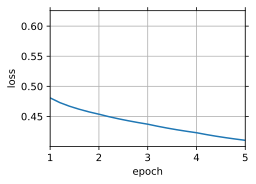

In [32]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 4.3. Applying Word Embeddings

After training the `word2vec` model, we can use the cosine similarity of word vectors from the trained model to find words from the dictionary that are most semantically similar to an input word.

In [39]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W*W, axis=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype("int32")
    for i in topk[1:]: # remove the input words
        print(f'cosine sim={float(cos[i]): .3f}: {vocab.to_tokens(i)}')

In [40]:
get_similar_tokens('chip', 3, net[0])

cosine sim= 0.714: microprocessor
cosine sim= 0.696: intel
cosine sim= 0.666: desktop
